In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [2]:
path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/twitter_reddit_text.csv'
core_path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/sorted_coefs_naivebayes_twitterreddit.csv'
data= pd.read_csv(f'{path}')
core_data = pd.read_csv(f'{core_path}')




In [3]:
core_data.head()

,Unnamed: 0,0
0,feel,-4.990164
1,depress,-5.006754
2,like,-5.237492
3,want,-5.350858
4,get,-5.560917


In [4]:
core_words = core_data['Unnamed: 0'].to_list()[:5000]
len(core_words)

5000

In [5]:
data.head()

,Unnamed: 0,clean_text,label
0,0,lay bed hour point back pain get work minut cl...,1
1,1,dlitedaili dont play wouldnt want anyth world,0
2,2,rewebcoach hey handsom time get day go,0
3,3,get readi tenni maryyi,0
4,4,hear song band almost never play favourit radi...,0


# sacarle al dataset core words

In [6]:
def stop_core_words(txt):
    txt = word_tokenize(str(txt))
    txt = ' '.join(word for word in txt if not word in core_words)
    return txt

In [7]:
data_stopped = data.clean_text.apply(stop_core_words)

# split, embed, and pad

In [11]:
X = data.clean_text #data_stopped si se quiere sacar corewords
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.3 )
print('length of X_train',len(X_train), 'length of X_test',len(X_test), 'length of y_train',len(y_train), 'length of y_test',len(y_test))

X_train = [word_tokenize(str(_)) for _ in X_train]
X_test = [word_tokenize(str(_)) for _ in X_test]


length of X_train 17757 length of X_test 7611 length of y_train 17757 length of y_test 7611


In [12]:
# This line trains an entire embedding for the words in your train set
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)


In [13]:
#cortamos en 400 words
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 400,truncating= 'post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 400 , truncating = 'post')


2022-03-09 18:56:59.182796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 18:56:59.182835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# cnn model

In [14]:
# Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    
    model.add(layers.Conv1D(20, kernel_size=3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'AUC','Precision','Recall'])
    
    return model

model = init_model()


2022-03-09 18:57:06.182286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-09 18:57:06.182332: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-09 18:57:06.182351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-QMHRL2V): /proc/driver/nvidia/version does not exist
2022-03-09 18:57:06.182679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose = 1
         )

2022-03-09 18:57:10.928210: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1988640000 exceeds 10% of free system memory.


Epoch 1/100
386/389 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9568 - auc: 0.9901 - precision: 0.9738 - recall: 0.9383

2022-03-09 18:57:34.447786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 852480000 exceeds 10% of free system memory.


389/389 [==============================] - 13s 22ms/step - loss: 0.1189 - accuracy: 0.9569 - auc: 0.9902 - precision: 0.9740 - recall: 0.9384 - val_loss: 0.0879 - val_accuracy: 0.9690 - val_auc: 0.9936 - val_precision: 0.9929 - val_recall: 0.9449
Epoch 2/100
389/389 [==============================] - 7s 19ms/step - loss: 0.0645 - accuracy: 0.9778 - auc: 0.9961 - precision: 0.9851 - recall: 0.9701 - val_loss: 0.0688 - val_accuracy: 0.9771 - val_auc: 0.9952 - val_precision: 0.9930 - val_recall: 0.9610
Epoch 3/100
389/389 [==============================] - 7s 18ms/step - loss: 0.0560 - accuracy: 0.9814 - auc: 0.9964 - precision: 0.9875 - recall: 0.9749 - val_loss: 0.0631 - val_accuracy: 0.9801 - val_auc: 0.9957 - val_precision: 0.9845 - val_recall: 0.9756
Epoch 4/100
389/389 [==============================] - 7s 17ms/step - loss: 0.0539 - accuracy: 0.9828 - auc: 0.9971 - precision: 0.9889 - recall: 0.9764 - val_loss: 0.0634 - val_accuracy: 0.9792 - val_auc: 0.9954 - val_precision: 0.9900 

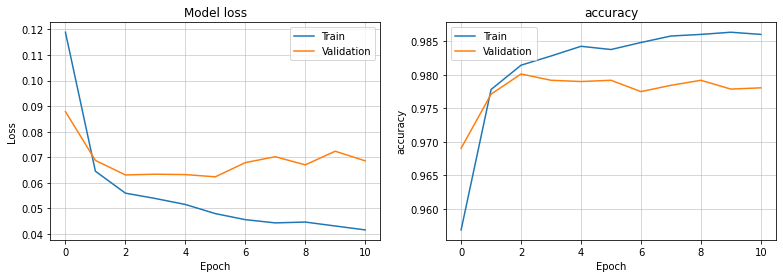

In [16]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

plot_loss(history_fit)

In [17]:
res = model.evaluate(X_test_pad, y_test, verbose = 1, return_dict=True)
res

2022-03-09 18:58:55.374019: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217760000 exceeds 10% of free system memory.


238/238 [==============================] - 2s 7ms/step - loss: 0.0648 - accuracy: 0.9781 - auc: 0.9959 - precision: 0.9880 - recall: 0.9682


{'loss': 0.0647510215640068,
 'accuracy': 0.9780580997467041,
 'auc': 0.9959272146224976,
 'precision': 0.9880223870277405,
 'recall': 0.96817946434021}